# Tanganyikan cichlid fish vs. flatworm parasites

This notebook reproduces the phylogeny of a parasitic interaction between cichlid fish in lake Tanganyika and their flatworm parasites. 

> *Hidden biodiversity in an ancient lake: phylogenetic congruence between Lake Tanganyika tropheine cichlids and their monogenean flatworm parasites*

> Maarten P. M. Vanhove, Antoine Pariselle, Maarten Van Steenberge, Joost A. M. Raeymaekers, Pascal I. Hablützel, Céline Gillardin, Bart Hellemans, Floris C. Breman, Stephan Koblmüller, Christian Sturmbauer, Jos Snoeks, Filip A. M. Volckaert & Tine Huyse

> Scientific Reports 5, Article number: 13669 (2015)

> doi:10.1038/srep13669

> https://www.nature.com/articles/srep13669

GenBank IDs for flatwork sequence data are found in Table 4.

> https://www.nature.com/articles/srep13669/tables/4

### Requirements

* [`jupyter`](http://jupyter.org/), obviously
* [`pandas`](http://pandas.pydata.org/) because data is happier in frames
* [`dendropy`](https://www.dendropy.org/) for trees and stuff
* [`BioPython`](http://biopython.org/), because someone has to talk to NCBI
* [`EMBOSS`](http://emboss.open-bio.org/), for the [`cons`](http://emboss.open-bio.org/rel/rel6/apps/cons.html) consensus caller

### Errata

One of the COI sequences (accession number `KT037397`) seems to be a Schistosoma sequence by nucleotide
identity, not a Cichlidogyrus sequence. Although there *are* Schistosoma organisms present in the region,
and they *could* have been found in the gills of the indicated host, and identification by morphology 
*could* have been mistaken, the authors tell me that they believe that this is most likely an error 
during DNA extraction and sequencing. I have excluded it, as they did in the analitical component of the 
original publication.

In [129]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [270]:
import pandas as pd

df = pd.read_csv( 'host_vs_parasite_GBIDs.csv' )
df.head()

,Host species,Country,Locality,RMCA (MRAC) accession numbers (host vouchers),Parasite rDNA,Parasite COI
0,Ctenochromis horei,Tanzania,Mtosi,B2-04-P-117,KT037139-41,KT037337
1,Ctenochromis horei,Zambia,Kalambo Lodge,"B2-04-P-119-131 (1,4,5,6,7,8,9,10,11)",KT037142-65,NaN
2,Ctenochromis horei,,Mbita Island,B2-04-P-118,KT037166-8,KT037338
3,Gnathochromis pfefferi,D.R. Congo,Mtoto,T10-2024,KT037169,KT037339
4,Gnathochromis pfefferi,Zambia,Kalambo Lodge,"B2-04-P-149-165 (1,2,3)",KT037170-3,KT037340-1


## Host tree

In [271]:
from Bio import Entrez
Entrez.email = "ryneches@ucdavis.edu"

def find_txid( species ) :
    handle = Entrez.esearch(db='taxonomy', term=species)
    record = Entrez.read(handle)
    if int(record['Count']) == 0 :
        raise Exception( 'no records found' )
    txid = record['IdList'][0]
    return txid

In [272]:
host_ids = {}
for name in set( df['Host species'] ) :
    host_id = find_txid( name )
    host_ids[ name ] = host_id
    print name, host_id

Tropheus moorii 8150
Simochromis babaulti 8156
Tropheus duboisi 8148
Petrochromis macrognathus 287480
Simochromis diagramma 43689
Serranochromis robustus 50903
Interochromis loocki 683192
Pseudosimochromis curvifrons 167848
Gnathochromis pfefferi 32498
Petrochromis trewavasae 244518
Lobochilotes labiatus 28810
Tropheus annectens 8146
Petrochromis polyodon 244514
Tropheus brichardi 8147
Petrochromis famula 244513
Simochromis marginatus 46578
Neolamprologus fasciatus 272721
Astatotilapia burtoni 8153
Limnotilapia dardennii 244511
Petrochromis fasciolatus 287489
Ctenochromis horei 194657


In [307]:
import dendropy

tree = dendropy.Tree.get(
    path='../../../fishpoo/host_tree/mcgeetree/mcgee_cichlids.tree',
    schema='newick')

tree.prune_taxa_with_labels( set( [ node.taxon.label for node in tree.leaf_nodes() ]) - set( df['Host species'] ) )

for node in tree.nodes() :
    if not node.parent_node :
        node.edge_length = 0

tree.write( path="host.tree", schema='newick' )

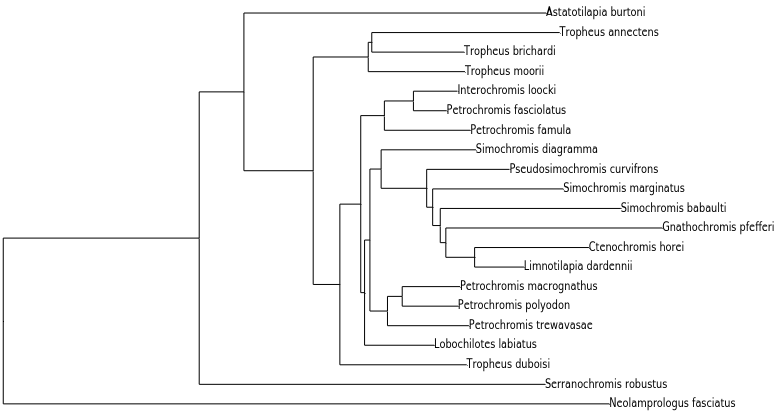

In [311]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0 

ete_tree = Tree( 'host.tree' )

#ete_tree.set_outgroup('Sema3')

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 1
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=220, units="mm", tree_style=ts)

## Parasite tree

In [386]:
parasite_COIs = {}
raw_links = {}

with open( 'parasite_COI.fasta', 'w' ) as f :
    
    for row,record in enumerate( df['Parasite COI'] ) :
        if not type( record ) == str : continue
        
        if not df['Host species'][row] in raw_links :
            raw_links[df['Host species'][row]] = []
        
        r = record.split('-')
        if len(r) == 1 :
            gbids = r
        else :
            l = len(r[1])
            start = int(r[0][2:])
            end = int(r[0][2:-l] + r[1])
            gbids = []
            for i in range( start, end+1 ) :
                gbids.append( r[0][:2] + '{0:06d}'.format(i) )
        parasite_COIs[row] = []
        for gbid in gbids :
        
            data = Entrez.read( Entrez.efetch( db='nucleotide', 
                                               id=gbid,
                                               retmode='xml' ) )[0]
            
            if data['GBSeq_definition'].split()[1] == 'sp.' :
                parasite_name = data['GBSeq_definition'].split()[2]
            else :
                parasite_name = data['GBSeq_definition'].split()[1]
            print gbid, parasite_name, data['GBSeq_definition']
            fasta = '>' + parasite_name + '\n' + data['GBSeq_sequence']
            raw_links[df['Host species'][row]].append( parasite_name )
            parasite_COIs[row].append( fasta )
            
        #print row, record, gbids

KT037337 T08_Mto_Ctho1_1KB4 Cichlidogyrus sp. T08_Mto_Ctho1_1KB4 cytochrome c oxidase subunit I (COI) gene, partial cds; mitochondrial
KT037338 T08_Mbi_Ctho1_1KB1 Cichlidogyrus sp. T08_Mbi_Ctho1_1KB1 cytochrome c oxidase subunit I (COI) gene, partial cds; mitochondrial
KT037339 GnPfC2 Cichlidogyrus sp. GnPfC2 cytochrome c oxidase subunit I (COI) gene, partial cds; mitochondrial
KT037340 Kal_Gnpf2_gill3 Cichlidogyrus sp. Kal_Gnpf2_gill3 cytochrome c oxidase subunit I (COI) gene, partial cds; mitochondrial
KT037341 GnaPfe3_2KB1 Cichlidogyrus sp. GnaPfe3_2KB1 cytochrome c oxidase subunit I (COI) gene, partial cds; mitochondrial
KT037342 Inlo1 Cichlidogyrus sp. Inlo1 cytochrome c oxidase subunit I (COI) gene, partial cds; mitochondrial
KT037343 Inlo2 Cichlidogyrus sp. Inlo2 cytochrome c oxidase subunit I (COI) gene, partial cds; mitochondrial
KT037344 Peor2 Cichlidogyrus sp. Peor2 cytochrome c oxidase subunit I (COI) gene, partial cds; mitochondrial
KT037345 Peor3 Cichlidogyrus sp. Peor3 c

In [387]:
parasite_rDNAs = {}

with open( 'parasite_rDNA.fasta', 'w' ) as f :
    
    for row,record in enumerate( df['Parasite rDNA'] ) :
        if not type( record ) == str : continue
        
        if not df['Host species'][row] in raw_links :
            raw_links[df['Host species'][row]] = []
        
        r = record.split('-')
        if len(r) == 1 :
            gbids = r
        else :
            l = len(r[1])
            start = int(r[0][2:])
            end = int(r[0][2:-l] + r[1])
            gbids = []
            for i in range( start, end+1 ) :
                gbids.append( r[0][:2] + '{0:06d}'.format(i) )
        parasite_rDNAs[row] = []
        for gbid in gbids :
        
            data = Entrez.read( Entrez.efetch( db='nucleotide', 
                                               id=gbid,
                                               retmode='xml' ) )[0]
            
            parasite_name = data['GBSeq_definition'].split()[2]
            fasta = '>' + parasite_name + '\n' + data['GBSeq_sequence']
            raw_links[df['Host species'][row]].append( parasite_name )
            parasite_rDNAs[row].append( fasta )
            
        print row, record, gbids

0 KT037139-41 ['KT037139', 'KT037140', 'KT037141']
1 KT037142-65 ['KT037142', 'KT037143', 'KT037144', 'KT037145', 'KT037146', 'KT037147', 'KT037148', 'KT037149', 'KT037150', 'KT037151', 'KT037152', 'KT037153', 'KT037154', 'KT037155', 'KT037156', 'KT037157', 'KT037158', 'KT037159', 'KT037160', 'KT037161', 'KT037162', 'KT037163', 'KT037164', 'KT037165']
2 KT037166-8 ['KT037166', 'KT037167', 'KT037168']
3 KT037169 ['KT037169']
4 KT037170-3 ['KT037170', 'KT037171', 'KT037172', 'KT037173']
5 KT037174-5 ['KT037174', 'KT037175']
6 KT037176-81 ['KT037176', 'KT037177', 'KT037178', 'KT037179', 'KT037180', 'KT037181']
7 KT037182-3 ['KT037182', 'KT037183']
8 KT037184-5 ['KT037184', 'KT037185']
9 KT037186 ['KT037186']
10 KT037187-90 ['KT037187', 'KT037188', 'KT037189', 'KT037190']
11 KT037191-2 ['KT037191', 'KT037192']
12 KT037193-4 ['KT037193', 'KT037194']
13 KT037195-230 ['KT037195', 'KT037196', 'KT037197', 'KT037198', 'KT037199', 'KT037200', 'KT037201', 'KT037202', 'KT037203', 'KT037204', 'KT037

Remove redundant observations (some parasite sequences are identical)

In [317]:
#seen_before = set()
#for row in parasite_rDNAs.keys() :
#    for record in parasite_rDNAs[row] :
#        if not record.split()[1] in seen_before :
#            seen_before.add( record.split()[1] )
#        else :
#            print 'seen before :', record.split()[0][1:]

parasite_seuqnces_rnda = []
for row in parasite_rDNAs.keys() :
    for record in parasite_rDNAs[row] :
        name = record.split()[0][1:]
        sequence = record.split()[1]
        
        parasite_seuqnces_rnda.append( { 'name' : name,
                                         'rDNA' : sequence } )
parasite_seuqnces_coi = []
for row in parasite_COIs.keys() :
    for record in parasite_COIs[row] :
        name = record.split()[0][1:]
        sequence = record.split()[1]
        parasite_seuqnces_coi.append( { 'name' : name,
                                        'COI'  : sequence } )

PS_r = pd.DataFrame( parasite_seuqnces_rnda ).set_index('name')
PS_c = pd.DataFrame( parasite_seuqnces_coi  ).set_index('name')
PS = pd.concat( [ PS_r, PS_c ], axis=1 )
PS.head()

,rDNA,COI
Asbu11_1,NaN,tttttttgggcatcctgaggtttatgtgttgattttacctggtttc...
Asbu11_2,NaN,tttttttgggcatcctgaggtttatgtgttgattttacctggtttc...
Cro_Peep1_1KB1,cactcttcatcgagtggtcgcgctttatgcagtttgctctgctcgg...,NaN
Cro_Peep1_1KB2,cactcttcatcgagtggtcgcgctttatgcagtttgctctgctcgg...,NaN
Cro_Peep1_1KB3,cgctcttcatcgagtggtcgcgctttaggcagtttgctctgctcgg...,NaN


32 records have identical rDNA and COI genes, so we'll drop those.

In [318]:
sum(PS.duplicated())

32

In [319]:
PS = PS.drop_duplicates()
with open( 'parasite_COI_uniq.fasta', 'w' ) as f :
    for name,seq in PS['COI'].dropna().iteritems() :
        f.write( '>' + name + '\n' + seq + '\n' )
with open( 'parasite_rDNA_uniq.fasta', 'w' ) as f :
    for name,seq in PS['rDNA'].dropna().iteritems() :
        f.write( '>' + name + '\n' + seq + '\n' )

In [320]:
!clustalo --force -v --threads 4 -i parasite_COI_uniq.fasta -o parasite_COI_aln.fasta
!echo
!clustalo --force -v --threads 4 -i parasite_rDNA_uniq.fasta -o parasite_rDNA_aln.fasta
!echo

Using 4 threads
Read 74 sequences (type: DNA) from parasite_COI_uniq.fasta
not more sequences (74) than cluster-size (100), turn off mBed
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 0.93u 0.00s 00:00:00.93 Elapsed: 00:00:01
Guide-tree computation done.
Progressive alignment progress done. CPU time: 6.57u 0.29s 00:00:06.86 Elapsed: 00:00:04
Alignment written to parasite_COI_aln.fasta

Using 4 threads
Read 167 sequences (type: DNA) from parasite_rDNA_uniq.fasta
Using 54 seeds (chosen with constant stride from length sorted seqs) for mBed (from a total of 167 sequences)
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 4.52u 0.00s 00:00:04.51 Elapsed: 00:00:02
mBed created 5 cluster/s (with a minimum of 1 and a soft maximum of 100 sequences each)
Distance calculation within sub-clusters done. CPU time: 2.28u 0.00s 00:00:02.27 Elapsed: 00:00:01
Guide-tree computation (mBed) done.
Progressive align

In [321]:
from Bio import AlignIO
from Bio.Nexus import Nexus
from Bio import Alphabet
from glob import glob

nexi = [ (alnfile, Nexus.Nexus( AlignIO.read( alnfile, 'fasta', alphabet=Alphabet.generic_dna  ).format('nexus') ) ) 
          for alnfile in glob( 'parasite_*_aln.fasta' ) ]
combined = Nexus.combine( nexi )
f = open('parasite.nex', 'w')
combined.write_nexus_data(f)
f.close()

# RAxML needs a phylip file
combined.export_phylip('parasite.phylip')

'parasite.phylip'

In [322]:
# RAxML partition file
f = open( 'parasite.txt', 'w' )
for key in combined.charsets.keys() :
    s = 'DNA, ' + key.split('_')[1] + ' = ' + str(combined.charsets[key][0]+1) + '-' + str(combined.charsets[key][-1]+1)
    f.write( s + '\n' )
    print s
f.close()

DNA, COI = 1389-1973
DNA, rDNA = 1-1388


In [323]:
!raxmlHPC -m GTRGAMMA -q parasite.txt -s parasite.phylip -n parasite -p 10001

Use raxml with AVX support (2 cpus)
RAxML output files with the run ID <parasite> already exist 
in directory /home/russell/Projects/SuchTree/data/fish-worm/ ...... exiting


In [324]:
!cp RAxML_bestTree.parasite guest.tree

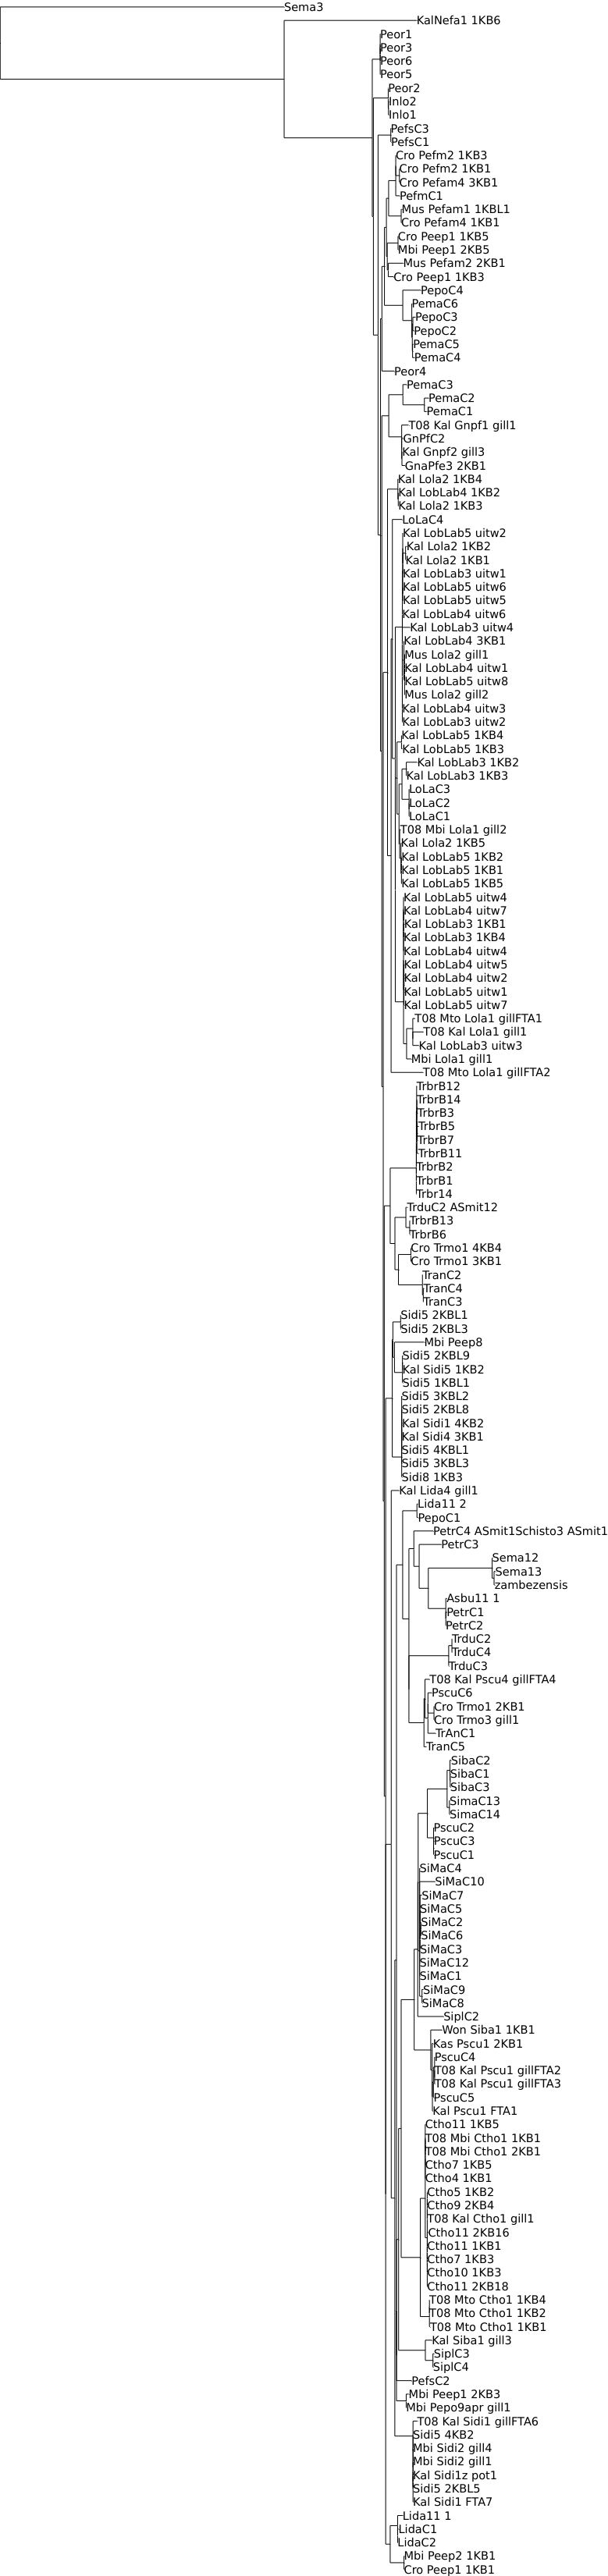

In [325]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0 

ete_tree = Tree( 'guest.tree' )

ete_tree.set_outgroup('Sema3')

ete_tree.

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 20
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=220, units="mm", tree_style=ts)

In [391]:
link_matrix = zeros( (len(set(df['Host species'])), len(set(PS.index))), dtype=int )
hostnames = [ name.replace(' ','_') for name in list(set(df['Host species'])) ]
parasitenames = list(set(PS.index))
for key,value in raw_links.iteritems() :
    for name in value :
        if name in parasitenames :
            i,j = hostnames.index( key.replace(' ','_') ), parasitenames.index( name )
            link_matrix[i,j] = 1

Links = pd.DataFrame( link_matrix, index=hostnames, columns=parasitenames )
Links.to_csv( 'links.csv' )

In [395]:
from SuchTree import SuchTree, SuchLinkedTrees

host_tree = SuchTree( 'host.tree' )
guest_tree = SuchTree( 'guest.tree' )
links = pd.read_csv( 'links.csv', index_col=0 )

SLT = SuchLinkedTrees( host_tree, guest_tree, links )

print 'links  :', SLT.n_links
print 'hosts  :', SLT.TreeA.n_leafs
print 'guests :', SLT.TreeB.n_leafs

links  : 191
hosts  : 21
guests : 191


In [396]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [398]:
sfeal = dict( zip( SLT.TreeB.leafs.values(), SLT.TreeB.leafs.keys() ) )
clade_leafs = [ sfeal[nodeid] for nodeid in SLT.subset_b_leafs ]

clinks = links[ clade_leafs ]
uclinks = clinks.applymap( bool ).unstack()
uclinks = uclinks[ uclinks ]
with open( 'temp.links', 'w' ) as f :
    for pair in list(uclinks.index) :
        f.write( '\t'.join([ ''+i+'' for i in pair[::-1] ]) + '\n' )

Rotating nodes to optimize matching...
Done.
png 
  2 


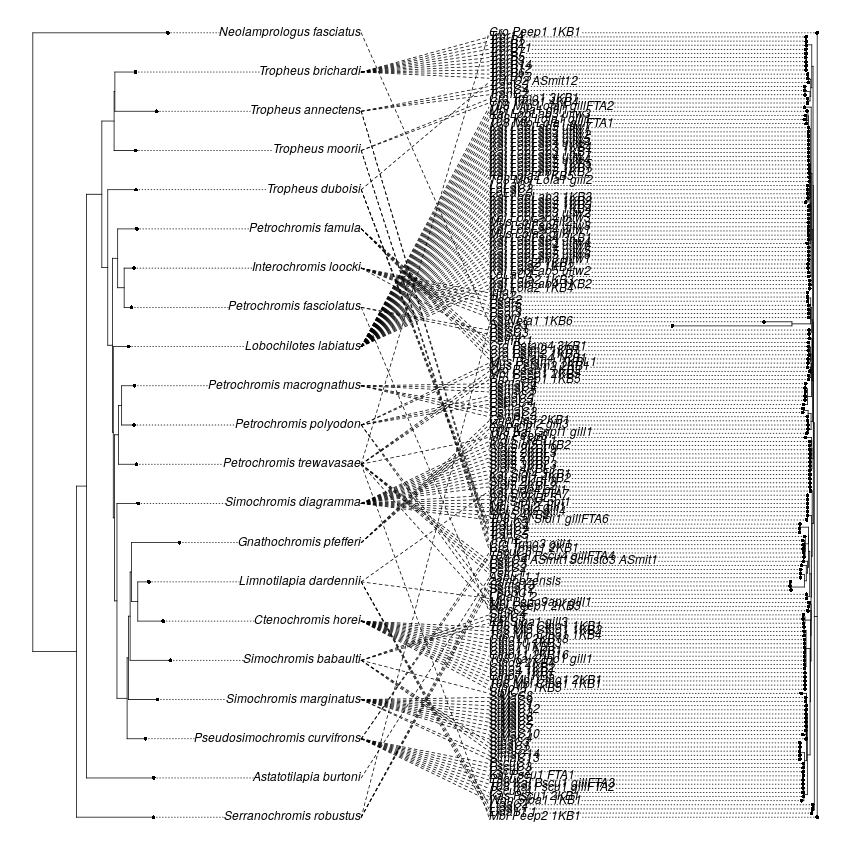

In [404]:
%%R -w 30 -h 30 -u cm

library('phytools')

tr1 <- read.tree( 'host.tree' )
tr2 <- read.newick( 'guest.tree' )
tr2 <- collapse.singles(tr2)
assoc = as.matrix(read.csv( 'temp.links', sep='\t', header=FALSE ))
colnames(assoc)<-c('tips.tr1','tips.tr2')

obj <- cophylo( tr1, tr2, assoc=assoc )
plot(obj)

pdf('fish-worm.pdf', width = 25, height = 25 )
plot(setMap(obj,invert=TRUE))
dev.off()

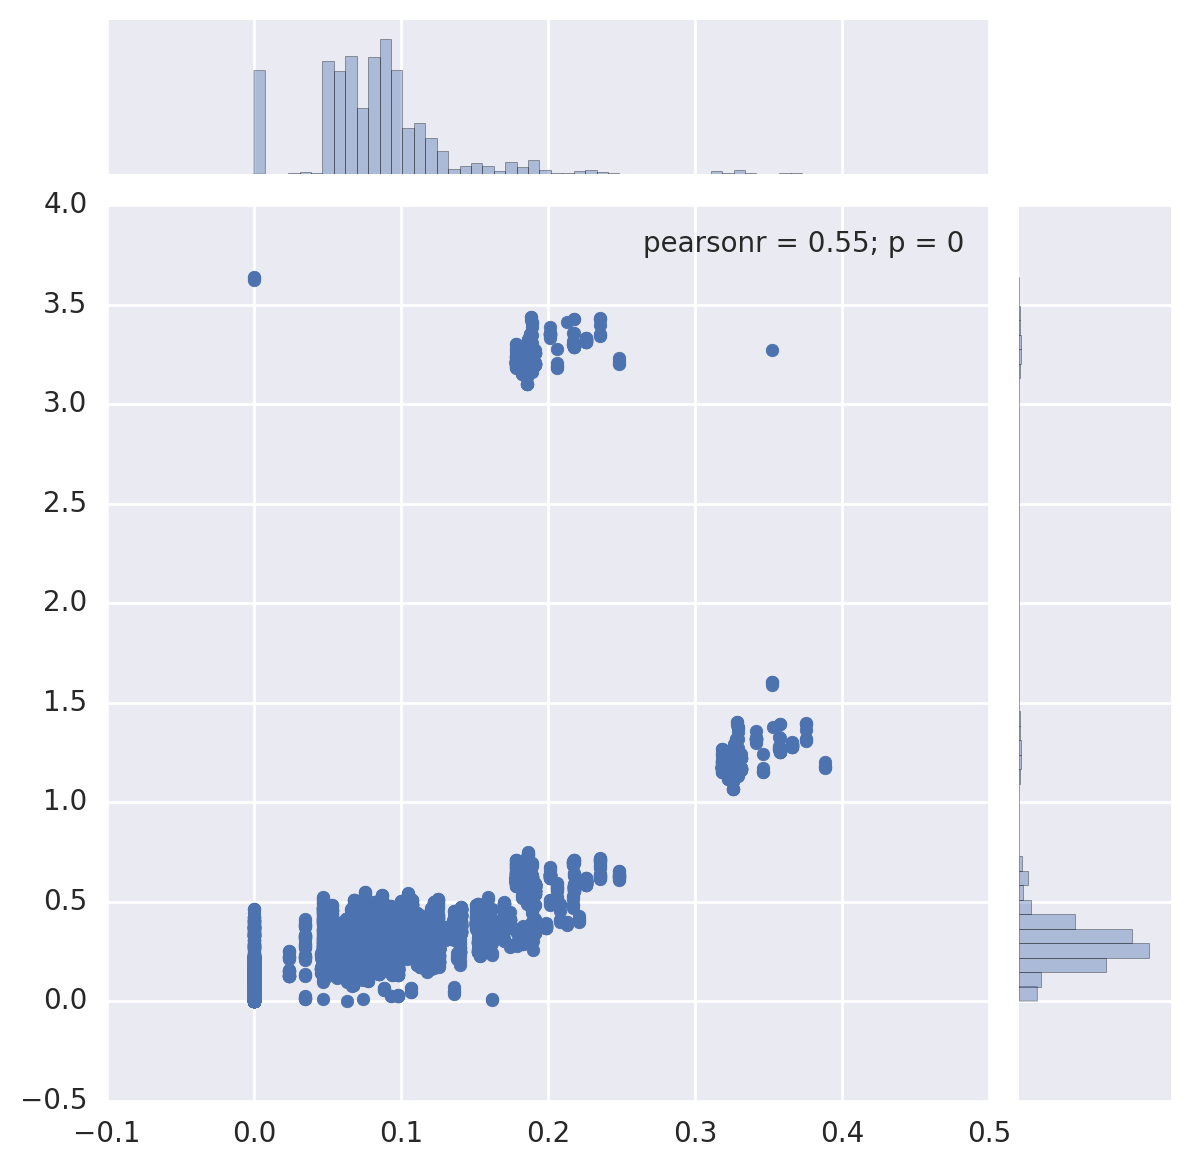

In [409]:
import seaborn
ld = SLT.linked_distances()

seaborn.jointplot( ld['TreeA'], ld['TreeB'] )